### Imports

In [11]:
#%matplotlib qt
#%matplotlib notebook
%matplotlib inline
import numpy as np
import pandas as pd
from keras.callbacks import TensorBoard, History, EarlyStopping
from keras.layers import Input, Dense, Dropout, LeakyReLU, Flatten
from keras.layers.convolutional import Conv1D
from keras.utils import plot_model
from keras.models import Model, Sequential
from pathlib import Path
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from evaluation import *

### Configuration

In [12]:
# fix random seed for reproducibility
np.random.seed(13)

## net params
num_layers = 3
num_neurons = 10
kernel_size = 2
filter_size = 32
act_fct = 'relu'
out_act = 'linear'
loss_fct = 'mae'
optim = 'adam'
metrics = []
history = History()
tilt_angles = [0, 10, 15, 18, 21, 25, 30, 35, 40, 45, 60, 90]
features = ['GHI', 'DHI', 'BHI', 'Tamb', 'POA_ISE', 'Rain', 'Tilt Angle', 'Ws', 'Wd']# time?
target = ['Pmpp']
timesteps = 16
shape = (timesteps + 1, len(features + target) + 1)

data_dir = './data/bifacial Oct2017-Oct2018/'
dir_ = './test_results_bifacial/'
set_dir(dir_)

## training params
tensorboard = False
callbacks = [history, EarlyStopping(patience=7, restore_best_weights=True)]
shuffle = True
epochs = 100
batch_size = 100
val_split = 1.0/10.0
forecast_horizon = 8

output directory set to ./test_results_bifacial/


### Create Dataset

In [13]:
fname = dir_ + 'data_step' + str(timesteps)

if Path(fname + '.npz').exists():
    print('Loading preprocessed dataset ...')
    with np.load(fname + '.npz') as datafile:
        trainX = datafile['trainX']
        trainY = datafile['trainY']
        testX = datafile['testX']
        testY = datafile['testY']
        idx = datafile['idx']
else:
    print('Data preprocessing ...')
    trainXs = []
    trainYs = []
    testXs = []
    testYs = []
    idxs = []
    
    dfs = list()
    for tilt in tilt_angles:
        df = pd.read_csv(data_dir + str(tilt) + '.csv', skipinitialspace=True, sep=';').set_index('TimeStamp')
        df = df[target + features]
        df['Tilt'] = df['Tilt Angle']

        # delete erroneous values
        df = df.drop(df['2018-09-12 10:00:00':'2018-09-17 09:00:00'].index)
        df['forecast_horizon'] = 0
        df = df[features + ['Tilt', 'forecast_horizon'] + target].dropna().reset_index().set_index(['TimeStamp', 'Tilt'])
        
        x = []
        for i in range(timesteps+1, len(df)+1):
            #sys.stdout.write("System %i/%i: %5i/%i                \r" % (s+1, num_sys, i, len(dataset)))
            #sys.stdout.flush()
            d = df.iloc[i-timesteps-1:i].copy()
            d.iloc[-1, -len(target):] = -1
            x.append(d.values)
        x = np.array(x)
        y = df[target].iloc[timesteps:]
        
        split = df[:'2018-07-29 07:00:00'].iloc[timesteps+1:].shape[0]
        trainX, testX = x[:split], x[split:]
        trainY, testY = y.iloc[:split].values, y.iloc[split:].values
        idx = y.iloc[split:].index

        trainXs.append(trainX)
        trainYs.append(trainY)
        testXs.append(testX)
        testYs.append(testY)
        idxs.append(idx)

    a = np.stack(trainYs, axis=1)
    trainY = a.reshape(a.shape[0]*a.shape[1], a.shape[2])

    a = np.stack(trainXs, axis=1)
    trainX = a.reshape(a.shape[0]*a.shape[1], a.shape[2], a.shape[3])

    a = np.stack(testYs, axis=1)
    testY = a.reshape(a.shape[0]*a.shape[1], a.shape[2])

    a = np.stack(testXs, axis=1)
    testX = a.reshape(a.shape[0]*a.shape[1], a.shape[2], a.shape[3])

    a = np.stack(idxs, axis=1)
    idx = a.reshape(a.shape[0]*a.shape[1])

    np.savez(fname, trainX=trainX, trainY=trainY, testX=testX, testY=testY, idx=idx)
    print('Saved to ' + fname + '.npz       ')
print('Preprocessing done.')

Loading preprocessed dataset ...
Preprocessing done.


### Create Model

In [14]:
model = Sequential()
model.add(Conv1D(filter_size, kernel_size, input_shape=shape, activation=act_fct, dilation_rate=1, padding='causal', kernel_initializer='he_uniform'))
for n in range(num_layers):
    model.add(Conv1D(filter_size, kernel_size, activation=act_fct, dilation_rate=2**(n+1), padding='causal', kernel_initializer='he_uniform'))
model.add(Flatten())
model.add(Dense(num_neurons, activation=act_fct, kernel_initializer='he_uniform'))
model.add(Dense(num_neurons, activation=act_fct, kernel_initializer='he_uniform'))
model.add(Dense(num_neurons, activation=act_fct, kernel_initializer='he_uniform'))
model.add(Dense(len(target)))
model.add(LeakyReLU(alpha=0.001))
model.compile(loss=loss_fct, optimizer=optim, metrics=metrics)

### Training

In [15]:
callbacks = callbacks
if tensorboard:
    print('tensorboard activated')
    callbacks.append(TensorBoard(log_dir='./tensorboard', histogram_freq=1, batch_size=batch_size, write_graph=True, write_grads=True, write_images=False))

model.fit(trainX, trainY, batch_size, epochs=epochs, validation_split=val_split, callbacks=callbacks, verbose=1)

Train on 21178 samples, validate on 2354 samples
Epoch 1/100
21178/21178 [==============================] - 5s 221us/step - loss: 22.7481 - val_loss: 12.9300
Epoch 2/100
21178/21178 [==============================] - 4s 166us/step - loss: 6.4343 - val_loss: 12.3448
Epoch 3/100
21178/21178 [==============================] - 4s 208us/step - loss: 4.9926 - val_loss: 8.2262
Epoch 4/100
21178/21178 [==============================] - 5s 245us/step - loss: 4.5168 - val_loss: 7.6367
Epoch 5/100
21178/21178 [==============================] - 3s 164us/step - loss: 4.2022 - val_loss: 5.9270
Epoch 6/100
21178/21178 [==============================] - 3s 165us/step - loss: 3.7353 - val_loss: 5.4197
Epoch 7/100
21178/21178 [==============================] - 3s 164us/step - loss: 3.6109 - val_loss: 11.6536
Epoch 8/100
21178/21178 [==============================] - 3s 164us/step - loss: 3.4408 - val_loss: 8.7559
Epoch 9/100
21178/21178 [==============================] - 3s 163us/step - loss: 3.1536 - v

In [16]:
draw_history(history)

### Prediction

In [17]:
model.epochs = 1
model.batch_size = 1024#1024#128
model.verbose = 0
#model.callbacks = [val_history] 
model.shuffle = True#False#True
wfvtraining = False
sliding_window = 120
threshold = -2000
val_div = 2.0
num_tilt = len(tilt_angles)

predictions = []
pred_err = []
length = len(testX) - forecast_horizon * num_tilt
trainset = []
trainy = []
perr = -1

for i in range(length):
    #if i == 1:#sliding_window + 1:
    #    model.callbacks.append(EarlyStopping(patience=7, restore_best_weights=True))#5 , baseline=600
    if i > sliding_window + 1 and wfvtraining:
        loss = h.history['loss'][-1]
        val_loss = min(h.history['val_loss'])
        model.epochs = 50
    else:
        loss = -1
        val_loss = -1

    sys.stdout.write("Walk-Forward Validation %5i/%i: %5.3f %5.3f, pred: %6.3f\r" % (i+1, length, loss, val_loss, perr))
    sys.stdout.flush()
    
    # initialize values for lagged power columns
    p = []
    for l in range(timesteps):
        p.append(testX[i,:][l][-1])
    ps = []
    ts = []
    ty = []
    for f in range(forecast_horizon):
        # build input vector for future timestep
        t = np.array([testX[i+(f*num_tilt)]])
        if t.size > 0:
            for l in range(timesteps-1):
                t[0][l,-1] = p[l]
                p[l] = p[l+1]
            t[0][-2,-1] = p[-1]
            t[0][:,-2] = f
            ts.append(t)
            ty.append(testY[i+(f*num_tilt)])

            # make prediction for input new vector
            p[-1] = model.predict(t).item(0)
            ps.append(p[-1])

    predictions.append(pd.DataFrame(ps))
    perr = np.mean(np.abs(np.concatenate(ty).flatten() - ps))
    pred_err.append(perr)

    if wfvtraining:
        trainset += ts
        trainy += ty
        if i - sliding_window >= 0:
            trainset = trainset[-(sliding_window*forecast_horizon):]
            trainy = trainy[-(sliding_window*forecast_horizon):]
        if  perr > threshold and (i+1) % num_tilt == 0:
            cond = [j//(forecast_horizon * num_tilt) - trainset[-j][0][0,-2] >= 0 for j in range(len(trainset), 0, -1)]

            dfX = np.array(trainset)[cond][:,0]
            dfY = np.array(trainy)[cond][:,0]
            
            # train with newly available data
            h = model.fit(dfX, dfY)#, val_idx=max(int(len(dfY) / val_div), 1))
            
prediction = pd.concat(predictions)

### Evaluation

In [18]:
comp = ''
plots = True#False#True
data_list = []
for tilt in range(num_tilt):
    directory = dir_ + 'tilt_' + str(tilt_angles[tilt]) + '/'
    set_dir(directory)
    meas = testY[tilt::num_tilt]
    index = idx[tilt::num_tilt]
    pred = pd.concat(predictions[tilt::num_tilt])
    data = pd.DataFrame()
    for i in range(forecast_horizon):
        data['+'+str(i+1)+'h-prediction'] = np.pad(pred[0][i].values, (i, 0), mode='constant', constant_values=(np.nan,))[:length]
        length = len(data)

    data['measured'] = pd.DataFrame(np.array(meas).reshape([len(meas), len(target)])).iloc[:,0]
    data = data.set_index(pd.MultiIndex.from_tuples(index[:length])).unstack()
    tmp = pd.DataFrame()
    tmp['measured'] = data[('measured', tilt_angles[tilt])]
    for i in range(forecast_horizon):
        tmp['+'+str(i+1)+'h-prediction'] = data['+'+str(i+1)+'h-prediction']
    data = tmp
    data.index = pd.to_datetime(data.index)
    data = data.dropna()
    
    m_col = data['measured']

    data.describe().to_csv(directory + 'description.csv', encoding='utf-8')
    data.corr(method='pearson').to_csv(directory + 'pearson.csv', encoding='utf-8')
    data.to_csv(directory + 'predictions.csv', encoding='utf-8')
    
    if plots:
        print('Tilt: ' + str(tilt_angles[tilt]))
        for horizon in range(1, forecast_horizon + 1):
            name = '+' + str(horizon) + 'h-prediction'
            p_col = data[name]

            walkForwardDailyLoss(m_col, p_col, None, comp, name, length_day=8)
            scatter_predictions(m_col, p_col, name)

            print('%s test RMSE: %.3f' % (name, math.sqrt(mean_squared_error(m_col, p_col))))
            draw_boxplot(m_col, p_col, None, '', name, title='Absolute power prediction error', outliers=False)

            plot_timeseries(m_col, p_col, None, comp, name)
            plot_timeseries(m_col, p_col, None, comp, name)

            daily_energy_error(m_col, p_col, None, comp, name, start='2015-10-13 00:00:00', length_day=8)

            draw_histogram(p_col, m_col, name)
        print()
        #plot_error_by_hour_of_day(data, None, 0, forecast_horizon)#1

    data_list.append(data)

output directory set to ./test_results_bifacial/tilt_0/
Tilt: 0
+1h-prediction test RMSE: 9.964
daily mean +1h-prediction absolute energy error: -40.903292737310615
daily mean +1h-prediction relative energy error: -4.017097884043794%
+2h-prediction test RMSE: 10.572
daily mean +2h-prediction absolute energy error: -44.87139700166881
daily mean +2h-prediction relative energy error: -4.460303435678707%
+3h-prediction test RMSE: 10.713
daily mean +3h-prediction absolute energy error: -46.27596703239875
daily mean +3h-prediction relative energy error: -4.653818879407722%
+4h-prediction test RMSE: 10.613
daily mean +4h-prediction absolute energy error: -45.59810693085012
daily mean +4h-prediction relative energy error: -4.647435917691003%
+5h-prediction test RMSE: 10.613
daily mean +5h-prediction absolute energy error: -45.85860275054669
daily mean +5h-prediction relative energy error: -4.724587690285146%
+6h-prediction test RMSE: 10.590
daily mean +6h-prediction absolute energy error: -45.

+7h-prediction test RMSE: 8.875
daily mean +7h-prediction absolute energy error: -28.568158599888243
daily mean +7h-prediction relative energy error: -3.047588167369578%
+8h-prediction test RMSE: 8.892
daily mean +8h-prediction absolute energy error: -28.68471842154626
daily mean +8h-prediction relative energy error: -3.109694015021252%

output directory set to ./test_results_bifacial/tilt_30/
Tilt: 30
+1h-prediction test RMSE: 8.217
daily mean +1h-prediction absolute energy error: -21.281507271200688
daily mean +1h-prediction relative energy error: -2.211396798408818%
+2h-prediction test RMSE: 8.545
daily mean +2h-prediction absolute energy error: -23.111506223787167
daily mean +2h-prediction relative energy error: -2.447706870273721%
+3h-prediction test RMSE: 8.629
daily mean +3h-prediction absolute energy error: -23.88575181593937
daily mean +3h-prediction relative energy error: -2.5755184978391834%
+4h-prediction test RMSE: 8.615
daily mean +4h-prediction absolute energy error: -23

+5h-prediction test RMSE: 9.249
daily mean +5h-prediction absolute energy error: -33.03159545885766
daily mean +5h-prediction relative energy error: -3.9797476548696618%
+6h-prediction test RMSE: 9.249
daily mean +6h-prediction absolute energy error: -33.12489501628983
daily mean +6h-prediction relative energy error: -4.043019517403413%
+7h-prediction test RMSE: 9.217
daily mean +7h-prediction absolute energy error: -32.90757183200388
daily mean +7h-prediction relative energy error: -4.062171985807231%
+8h-prediction test RMSE: 9.243
daily mean +8h-prediction absolute energy error: -33.17699306491357
daily mean +8h-prediction relative energy error: -4.139989041702008%



##############################################


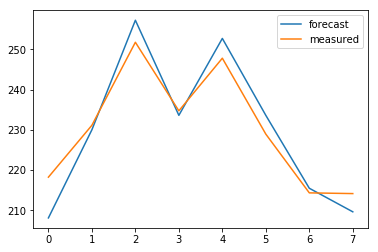

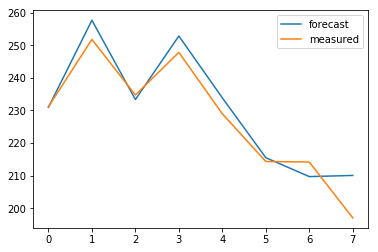

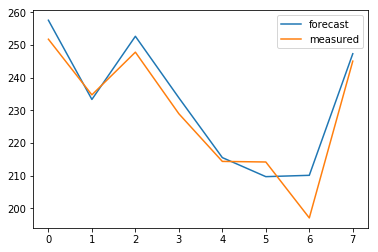

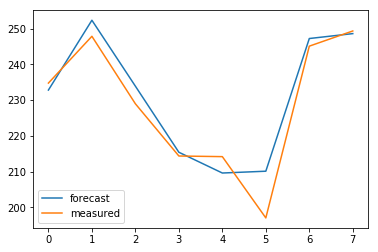

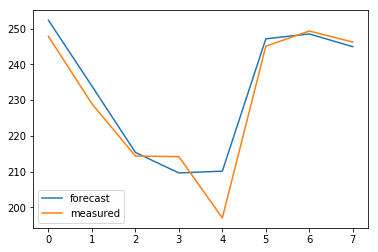

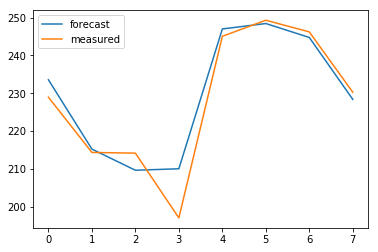

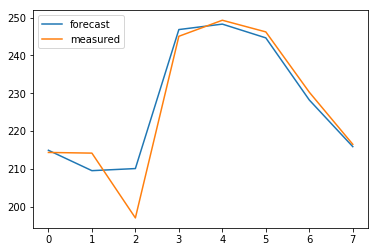

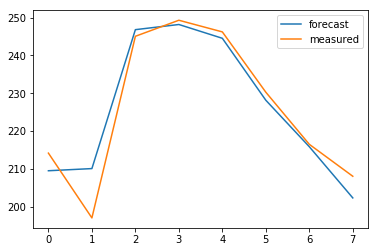

##############################################


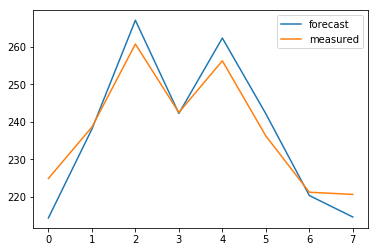

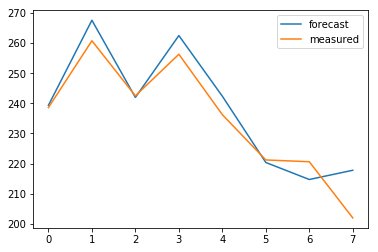

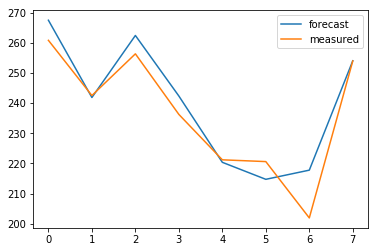

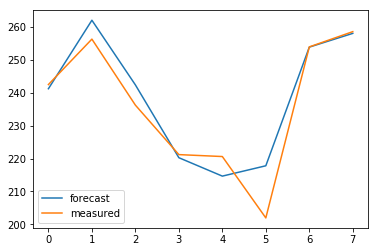

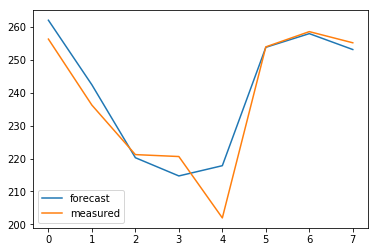

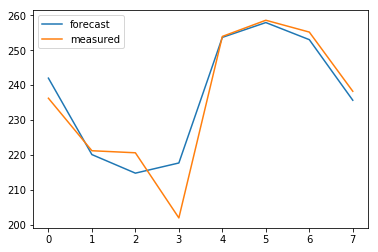

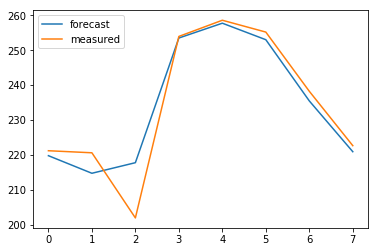

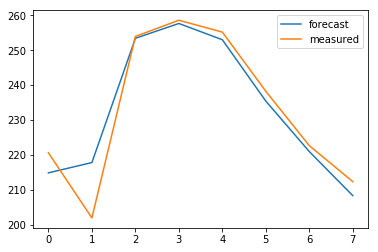

##############################################


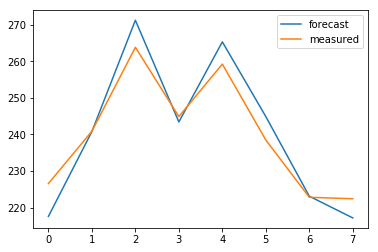

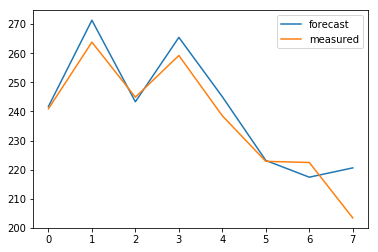

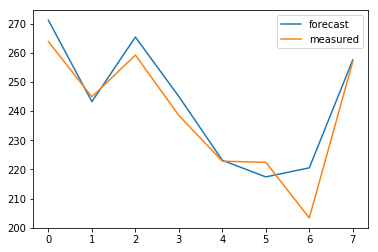

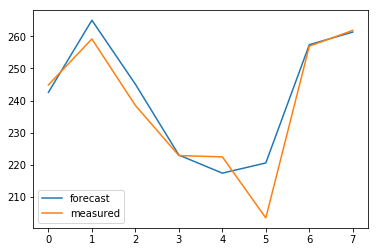

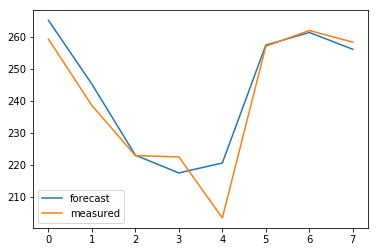

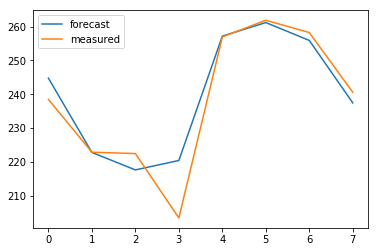

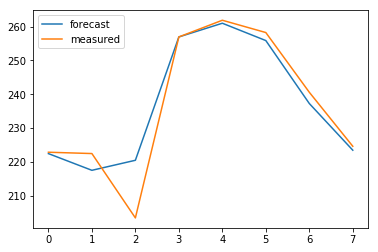

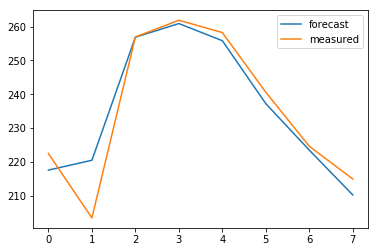

##############################################


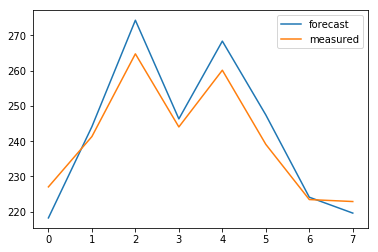

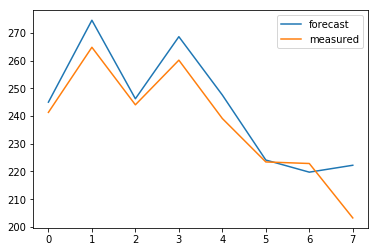

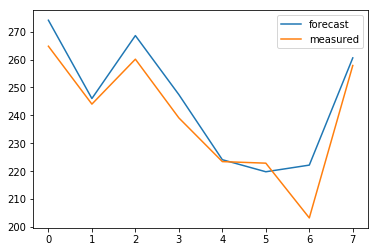

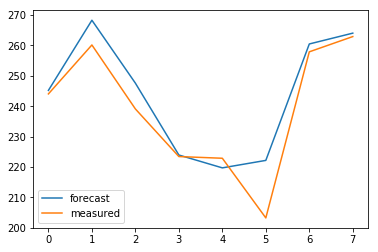

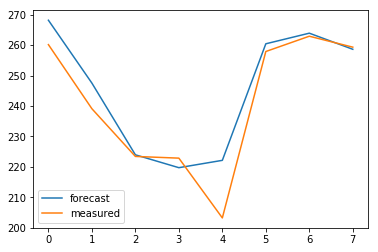

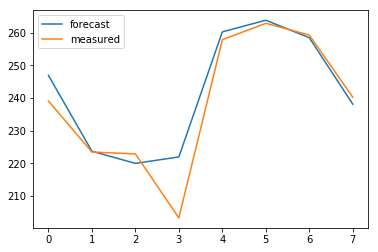

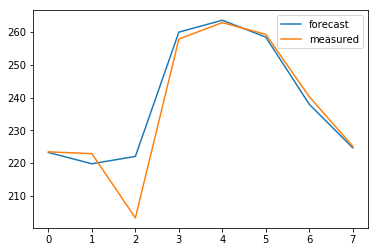

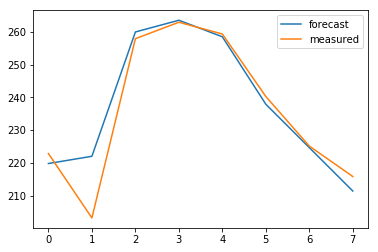

##############################################


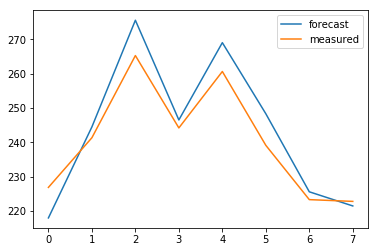

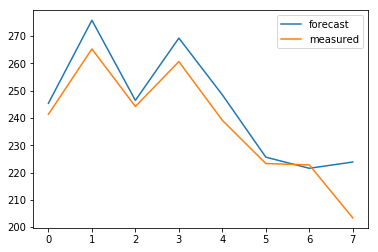

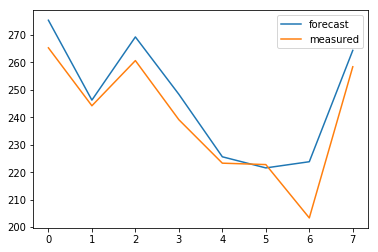

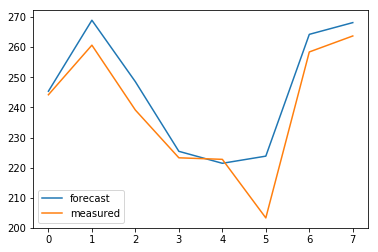

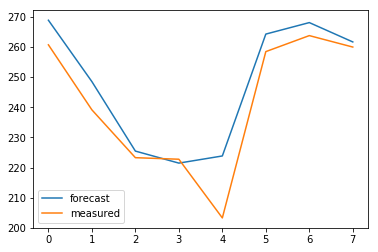

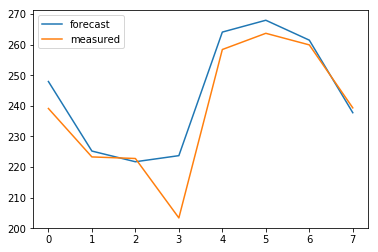

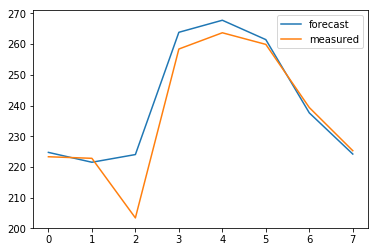

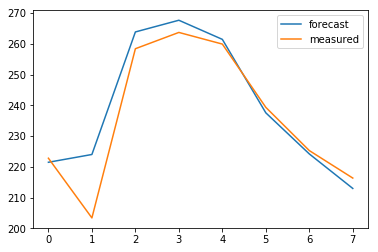

##############################################


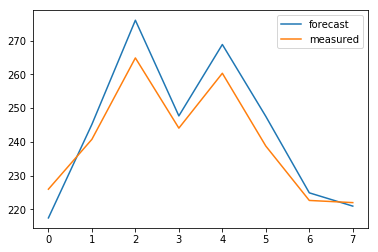

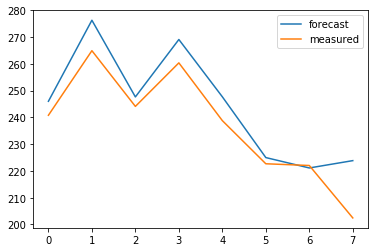

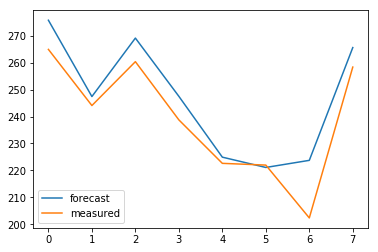

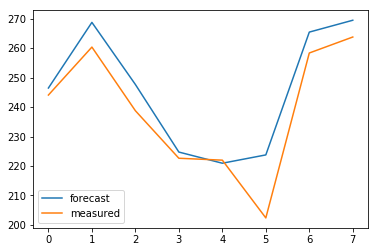

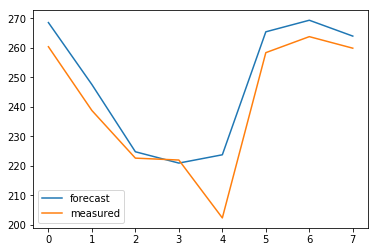

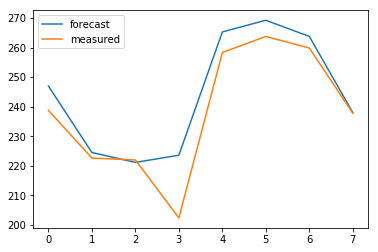

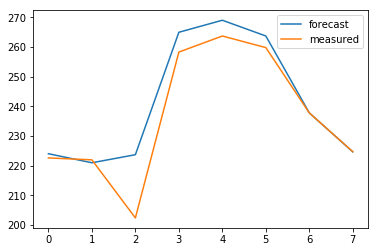

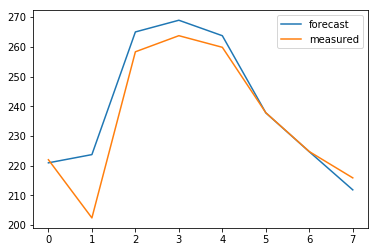

##############################################


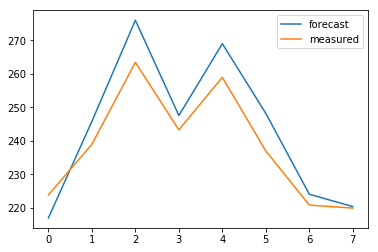

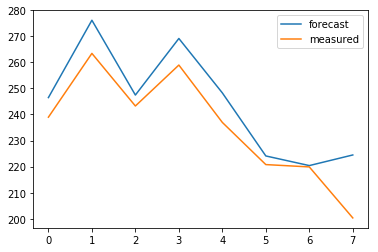

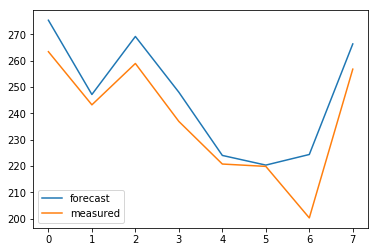

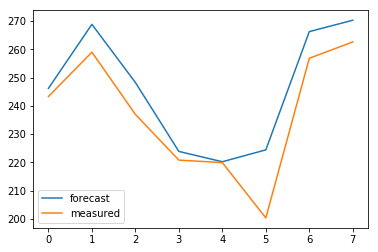

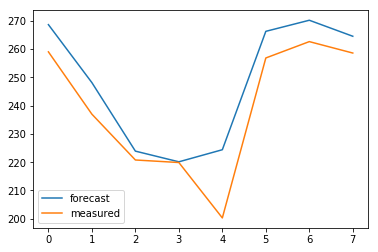

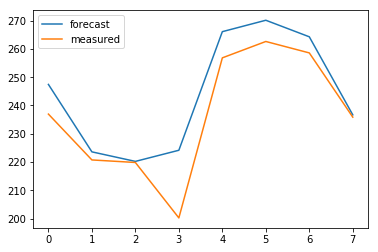

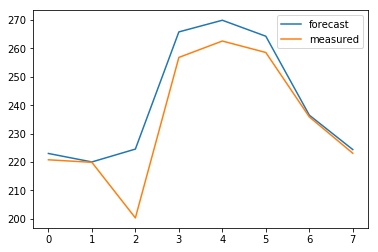

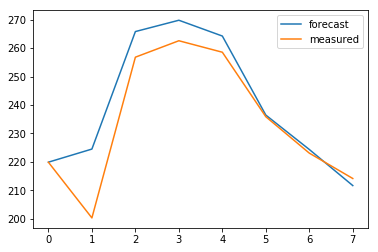

##############################################


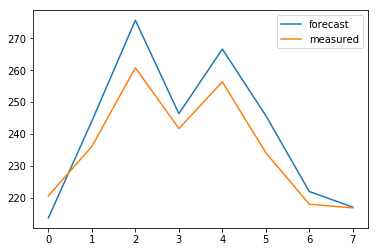

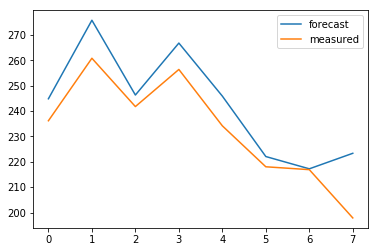

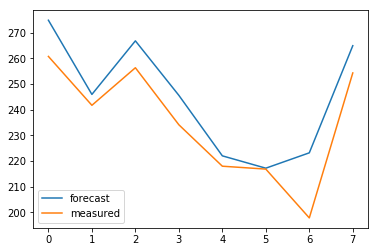

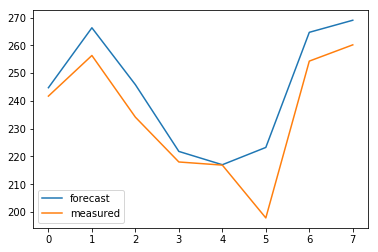

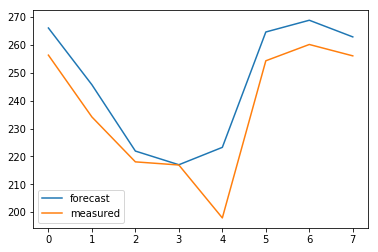

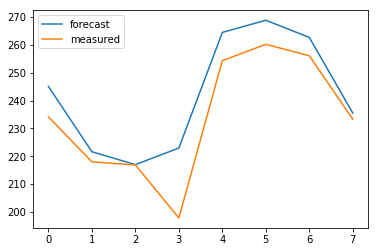

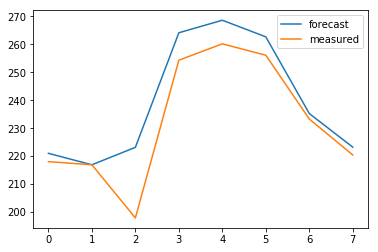

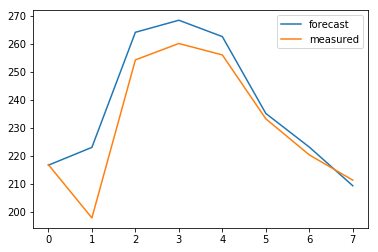

##############################################


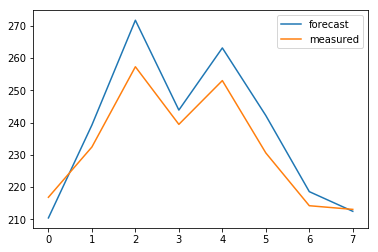

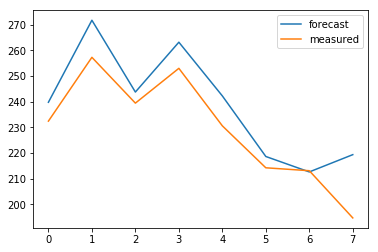

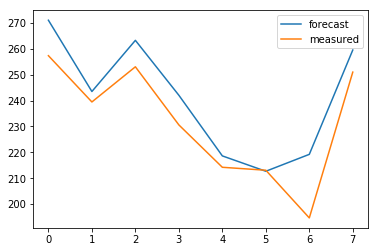

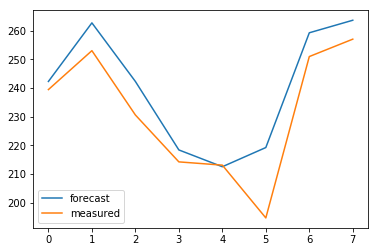

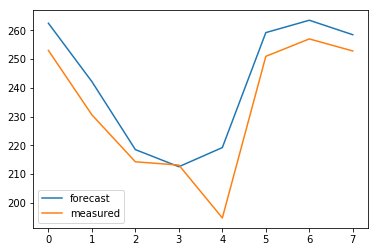

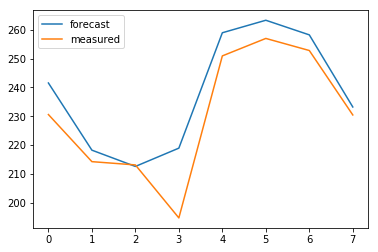

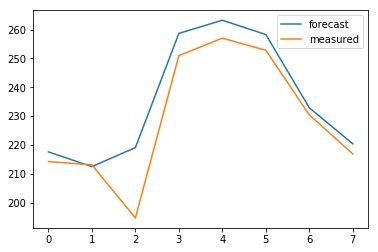

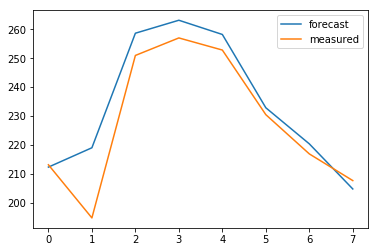

##############################################


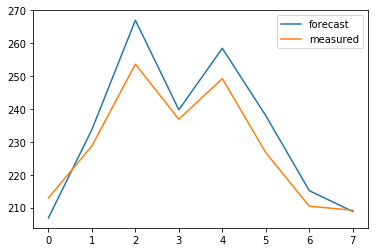

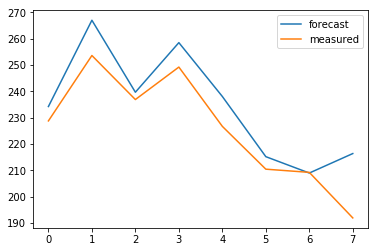

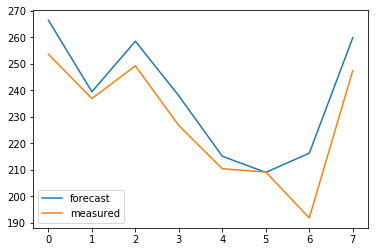

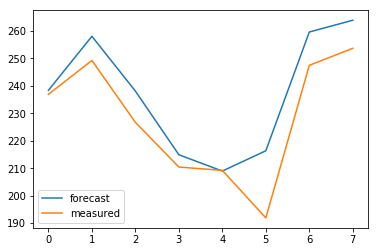

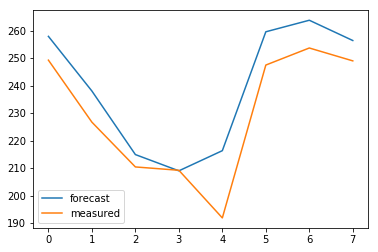

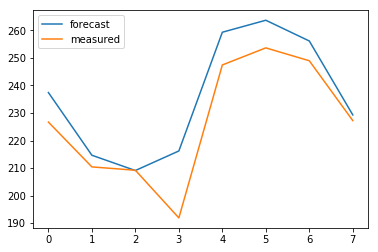

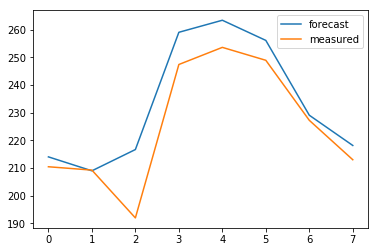

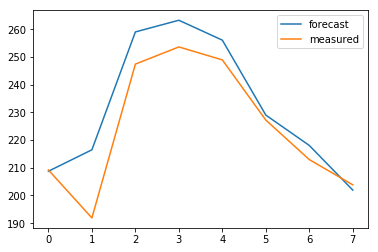

##############################################


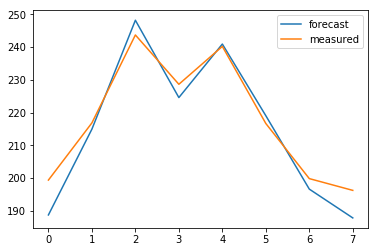

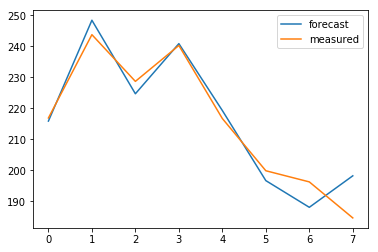

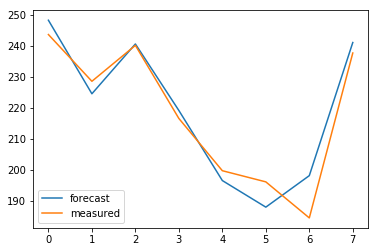

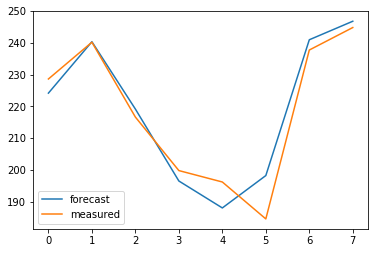

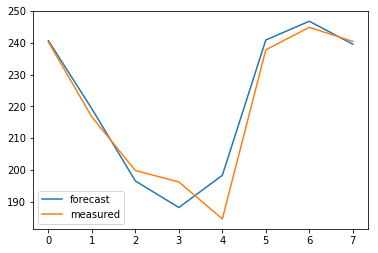

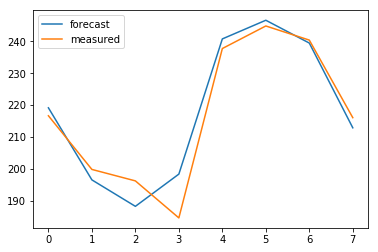

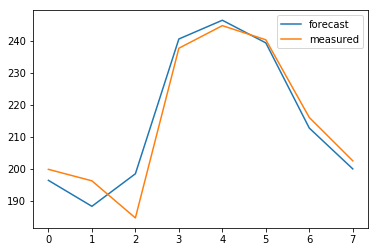

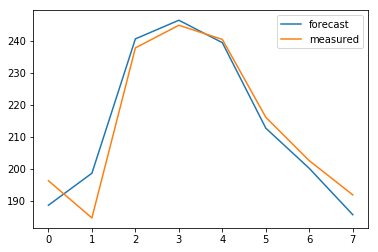

##############################################


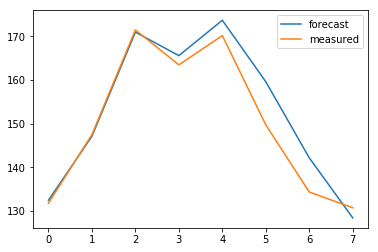

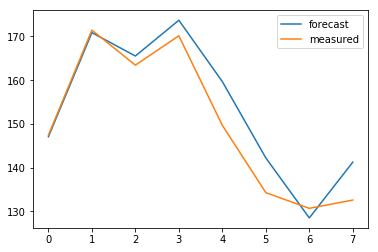

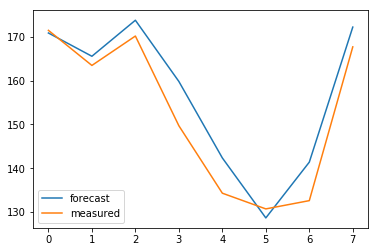

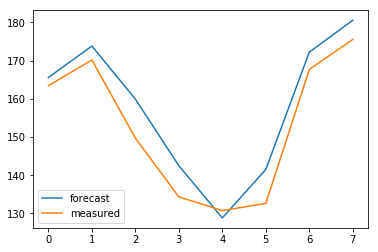

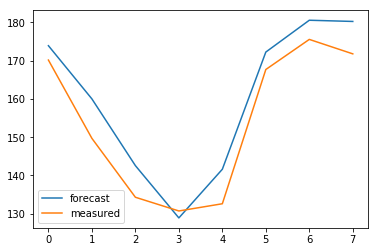

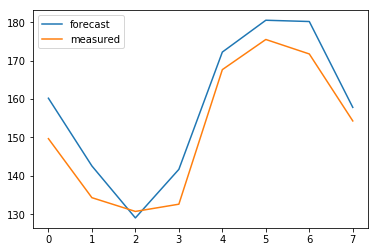

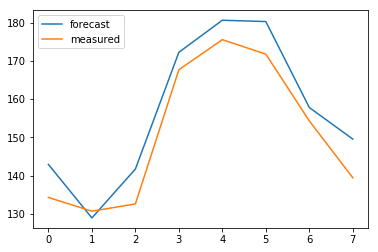

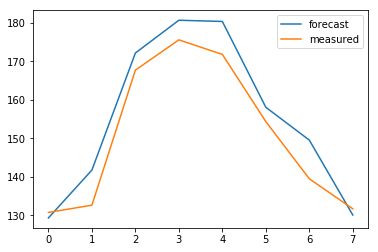

In [21]:
d = 0
for data in data_list:
    print('##############################################')
    for i in range(d, d+forecast_horizon):
        forecast = []
        for f in range(1, forecast_horizon+1):
            forecast.append(data['+'+str(f)+'h-prediction'].iloc[f-1 + i])
        a = pd.DataFrame()
        a['forecast'] = forecast
        a['measured'] = data['measured'].iloc[i:forecast_horizon+i].values
        a.plot()
        plt.show()

652/652
10.561701486732114


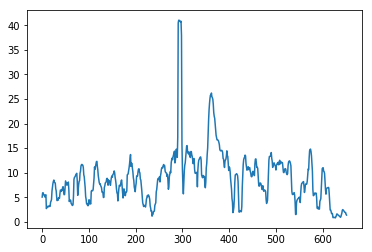

652/652
10.414048483115431


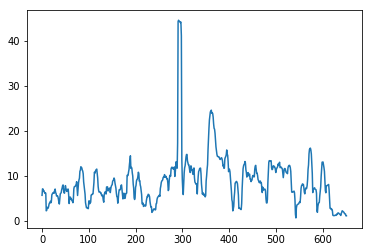

652/652
10.007090502081704


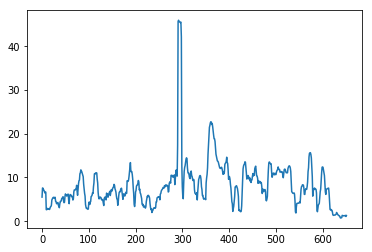

652/652
9.69627811610922


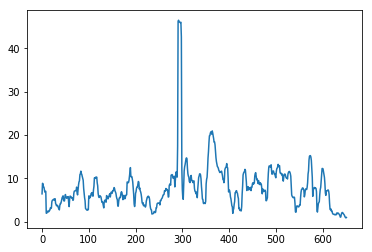

652/652
9.367135082362857


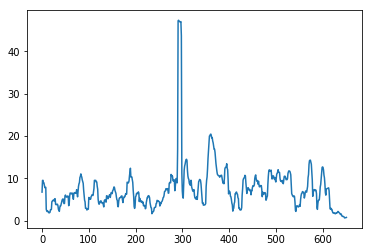

652/652
8.859631992652812


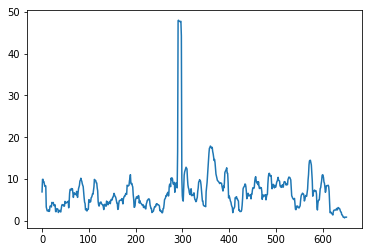

652/652
8.595698518125086


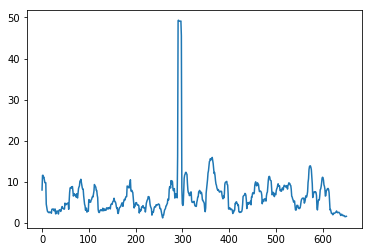

652/652
8.435593839387364


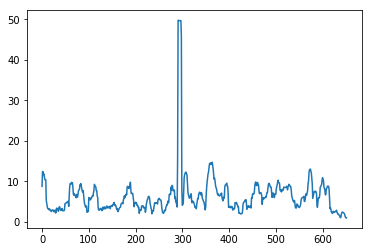

652/652
8.36174153236987


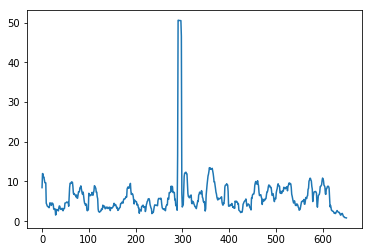

652/652
8.305501712504196


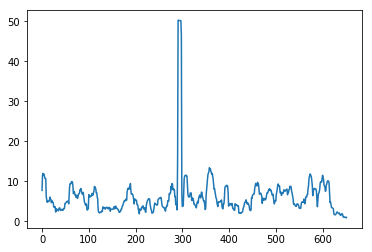

652/652
8.81418051006995


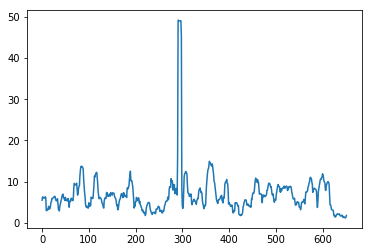

652/652
9.196779492272238


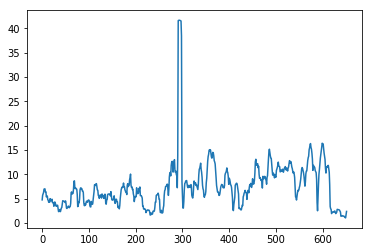

In [20]:
for data in data_list:
    l = []
    for i in range(len(data)-(forecast_horizon-1)):
        sys.stdout.write("%i/%i\r" % (i+1, len(data)-(forecast_horizon-1)))
        sys.stdout.flush()
        forecast = []
        for f in range(1, forecast_horizon+1):
            forecast.append(data['+'+str(f)+'h-prediction'].iloc[f-1 + i])
        a = pd.DataFrame()
        a['forecast'] = forecast
        a['measured'] = data['measured'].iloc[i:forecast_horizon+i].values
        l.append(mean_squared_error(a.measured, a.forecast))
    print()
    print(math.sqrt(pd.DataFrame(l).mean().values[0]))

    plt.plot(np.sqrt(l))
    plt.show()